# Predicting Energy Prices in Spain
In this project we will create a linear dynamical system (LDS) in Pyro in order to analyze and forecast energy prices in Spain.

In [4]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 283 kB 9.6 MB/s 


In [5]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from tqdm import tqdm
import scipy

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

import time

# fix MCMCndom generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

The data consists of time-series of consumption of different energy sources in different Spanish cities that a geographically well distributed across Spain. The data has $T = 178181$ time points.

In [7]:
def get_data():
    # all data
    df = pd.read_csv("preprocessed_data/df.csv") 
    X = df

    # weather data
    dfW = df[['temp', 'temp','temp_min','temp_max','pressure','humidity','wind_speed','wind_deg','rain_1h','rain_3h','snow_3h']].copy()

    # Set outliers to mean
    #dfW["pressure"] = dfW["pressure"].apply(lambda p: dfW["pressure"].mean() if )
    dfW.loc[(df["pressure"] > 1e4) | (df["pressure"] < 1e2), "pressure"] = df["pressure"].mean()

    # Normalize stuff
    dfW['temp'] = (dfW['temp'] - 273.15) / 50
    dfW['temp_min'] = (dfW['temp_min'] - 273.15) / 50
    dfW['temp_max'] = (dfW['temp_max'] - 273.15) / 50
    dfW['pressure'] = (dfW["pressure"] - 1013) / 1e3
    dfW['humidity'] = dfW["humidity"] / 100
    dfW['wind_speed'] = dfW["wind_speed"] / 50
    dfW['wind_deg'] = dfW["wind_deg"] / 360
    dfW['rain_1h'] = dfW["rain_1h"] / 1e3
    dfW['rain_3h'] = dfW["rain_3h"] / 1e3
    dfW['snow_3h'] = dfW["snow_3h"] / 1e3

    X_W = dfW

    # energy data
    dfE = df[['generation biomass', 'generation fossil',
       'generation hydro', 'generation nuclear', 'generation other',
       'generation other renewable', 'generation solar', 'generation total',
       'generation waste', 'generation wind onshore']]

    X_E = dfE

    # price
    y = df['price actual']


    return X_W, X_E, y

X_W, X_E, Y = get_data()

Some basic data statistics:

In [8]:
print("Weather Dataset size:", len(X_W))
print("General statistics:")
X_W.describe()

Weather Dataset size: 24810
General statistics:


,temp,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h
count,24809.000000,24809.000000,24809.000000,24809.000000,24809.000000,24809.000000,24809.000000,24809.000000,24809.000000,24809.000000,24809.000000
mean,0.309113,0.309113,0.297137,0.322397,-0.001198,0.669366,0.052146,0.502144,0.000161,0.000002,0.000034
std,0.176172,0.176172,0.164618,0.193676,0.027315,0.226131,0.046785,0.297088,0.000673,0.000010,0.000596
min,-0.218200,-0.218200,-0.218200,-0.218200,-0.419000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.185600,0.185600,0.183490,0.187340,-0.002000,0.510000,0.020000,0.219444,0.000000,0.000000,0.000000
50%,0.285300,0.285300,0.282000,0.287527,0.005000,0.710000,0.040000,0.550000,0.000000,0.000000,0.000000
75%,0.429200,0.429200,0.406674,0.443780,0.010000,0.860000,0.080000,0.752778,0.000000,0.000000,0.000000
max,0.823600,0.823600,0.800000,0.960000,0.379591,1.000000,1.280000,1.000000,0.012000,0.000100,0.021500


In [9]:
print("Energy Dataset size:", len(X_E))
print("General statistics:")
X_E.describe()

Energy Dataset size: 24810
General statistics:


,generation biomass,generation fossil,generation hydro,generation nuclear,generation other,generation other renewable,generation solar,generation total,generation waste,generation wind onshore
count,24809.000000,24809.000000,24809.000000,24809.000000,24809.000000,24809.000000,24809.000000,24809.00000,24809.000000,24809.000000
mean,478.500141,10794.841912,4342.108428,6218.728768,75.563344,68.849692,1560.401951,29867.27619,214.822282,6113.459672
std,57.470228,3671.553174,1702.433699,948.124387,18.094890,6.438270,1721.486794,4027.96792,44.733017,3383.819444
min,101.000000,3398.000000,1106.000000,3712.000000,5.000000,14.000000,12.000000,17329.00000,39.000000,260.000000
25%,446.000000,7703.000000,3024.000000,5058.000000,77.000000,65.000000,110.000000,26729.00000,177.000000,3356.000000
50%,485.000000,10868.000000,4104.000000,6693.000000,84.000000,69.000000,700.000000,29520.00000,216.000000,5670.000000
75%,522.000000,13271.000000,5478.000000,7095.000000,86.000000,73.000000,2887.000000,32534.00000,258.000000,8323.000000
max,590.000000,21558.000000,10526.000000,7113.000000,106.000000,87.000000,5668.000000,40766.00000,295.000000,17436.000000


Visualize data (part of it):

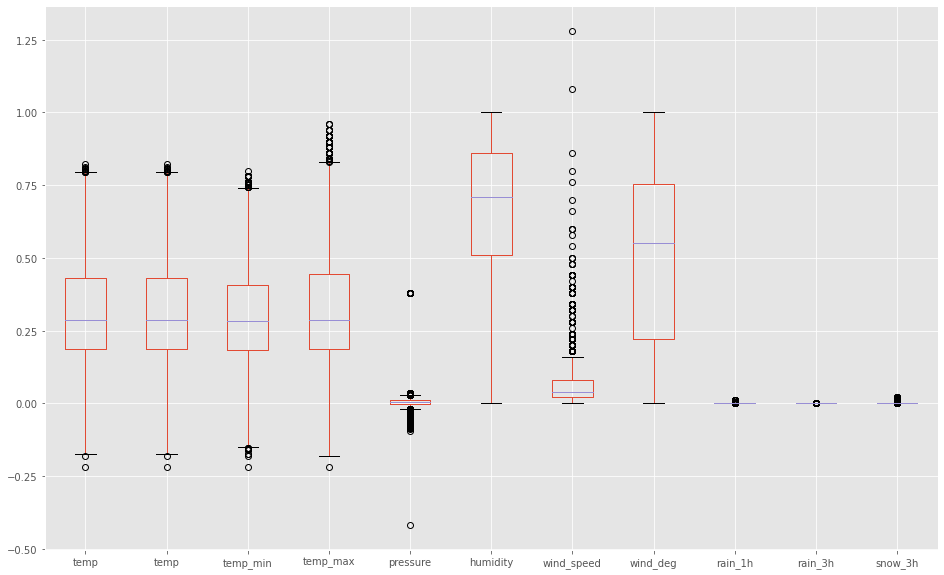

In [10]:
X_W.boxplot()

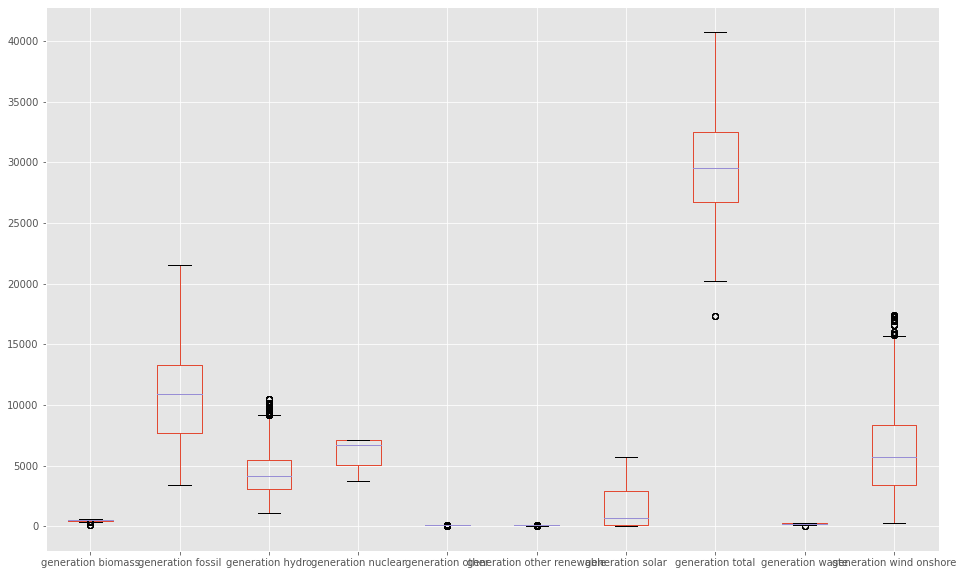

In [11]:
X_E.boxplot()

Split data into a trainset and a testset (which we wish to forecast):

In [12]:
# define constants
n, p = X_E.shape

# start, train end, test end
T0 = 0
T1 = n - n//10 # 10 % test data
T2 = n


y = Y.values
xw_train = torch.from_numpy(X_W[T0:T1].values).float()
xw_test = torch.from_numpy(X_W[T1:T2].values).float()
xe_train = torch.from_numpy(X_E[T0:T1].values).float()
xe_test = torch.from_numpy(X_E[T1:T2].values).float()
y_train = torch.from_numpy(y[T0:T1]).float().unsqueeze(-1)
y_test = torch.from_numpy(y[T1:T2]).float().unsqueeze(-1)

N_train = len(xe_train)
N_test = len(xe_test)

print("Number of observations:", n)
print("Number of training observations:", T1 - T0)
print("Number of test observations:", T2 - T1)

Number of observations: 24810
Number of training observations: 22329
Number of test observations: 2481


In [14]:
def f(carry, t):
  h_prev1, X_W, X_E, beta, theta_f, theta_g, R = carry
  z_t = numpyro.sample(name="z", fn=dist.Categorical(X_W[t] @ beta), infer={"enumerate": "parallel"})
  X_t = jnp.concatenate([X_W[t], X_E[t], h_prev1], axis=0)
  h_t = numpyro.sample(name="h", fn=dist.Normal(X_t @ theta_f[:,z_t], R[:,z_t]))
  y_t = numpyro.sample(name="y", fn=dist.Normal(h_t @))

  h_prev1 = h_t
  return (h_prev1, X_W, X_E, beta, theta_f, R), 

SyntaxError: ignored

Can you put all of this together and define the Pyro Model for the AR(2) model?

In [ ]:
from torch._C import ByteStorageBase

def model(X_E, X_W, M, lam_f, lam_g, beta_sig, R_gamma, y_tau, h_dim, T, T_forecast, obs=None):
    theta_dim = X_W.shape[1] + X_E.shape[1] + h_dim
    with numpyro.plate("season", M):
        with numpyro.plate("theta_dim", theta_dim):
          theta_f = numpyro.sample(name="theta_f", fn=dist.Normal(0, lam_f))

        with numpyro.plate("h_dim", h_dim):
          R = numpyro.sample(name="R", fn=dist.HalfCauchy(R_gamma))

        with numpyro.plate("X_W_dim", X_W.shape[1]):
          beta = numpyro.sample(name="beta", fn=dist.Normal(0, beta_sig))


    y_sigma = numpyro.sample(name="y_sigma", fn=dist.HalfCauchy(y_tau))      
    h0 = np.ones(h_dim)
    t0 = 0
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (t0, h0, X_W, X_E, beta, theta_f, R)
    # h_collection = [h0]
    with numpyro.handlers.condition(data={"y": y[1:]}):
      carry_updated, ys = lax.scan(f, carry, jnp.arange(1, T+T_forecast-1))
    # h_collection = jnp.concatenate((jnp.array(h_collection), hs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_pred) 
    """
    # numpyro.sample(name="y_obs", fn=dist.Normal(loc=h_collection[:T], scale=y_sigma), obs=obs[:T])
    # numpyro.sample(name="y_pred", fn=dist.Normal(loc=h_collection[T:], scale=y_sigma), obs=None)
    # return h_collection
    return ys

In [314]:

# from torch._C import ByteStorageBase

# def model(X_E, X_W, M, lam_f, lam_g, beta_sig, R_gamma, y_tau, h_dim, T, T_forecast, obs=None):
#     """ 
      
#     """
#     betas = []
#     theta_fs = []
#     Rs = []
#     print("Creating seasonal priors")
#     for m in tqdm(range(M)):
#       theta_f = []
#       theta_dim = X_W.shape[1] + X_E.shape[1] + h_dim
#       for _ in range(h_dim):
#         theta = numpyro.sample(name=f"theta_{m}_{_}", fn=dist.Normal(np.zeros(theta_dim), np.eye(theta_dim)*lam_f))
#         theta_f.append(theta)
      
#       theta_f = np.stack(theta_f)
#       # theta_g = numpyro.sample(name="theta_g", fn=dist.Normal(np.zeros(M), np.eye(M)*lam_g ))
#       R = numpyro.sample(name=f"R_{m}", fn=dist.HalfCauchy(np.eye(h_dim)*R_gamma))
#       beta = numpyro.sample(name=f"beta_{m}", fn=dist.Normal(np.zeros(X_W.shape[1]), np.ones(X_W.shape[1])*beta_sig))
#       theta_fs.append(theta_f)
#       Rs.append(R)
#       betas.append(beta)

#     betas = np.stack(betas, axis=1)
#     y_sigma = numpyro.sample(name="y_sigma", fn=dist.HalfCauchy(y_tau))      
#     h0 = np.ones(h_dim)
#     t0 = 0
    
#     """ Propagate the dynamics forward using jax.lax.scan
#     """
#     carry = (t0, h0, X_W, X_E, betas, theta_fs, Rs)
#     h_collection = [h0]
#     carry_updated, hs_exp = lax.scan(f, carry, None, T+T_forecast-1)
#     h_collection = jnp.concatenate((jnp.array(h_collection), hs_exp), axis=0)
    
#     """ Sample the observed_y (y_obs) and predicted_y (y_pred) 
#     """
#     numpyro.sample(name="y_obs", fn=dist.Normal(loc=h_collection[:T], scale=y_sigma), obs=obs[:T])
#     numpyro.sample(name="y_pred", fn=dist.Normal(loc=h_collection[T:], scale=y_sigma), obs=None)
#     return h_collection

Run inference using MCMC:

In [15]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)

mcmc.run(rng_key_, X_E=xe_train.numpy(), X_W=xw_train.numpy(), M=4, lam_f=1., lam_g=1., beta_sig=1., R_gamma=1., y_tau=1., h_dim=10, T=N_train, T_forecast=N_test, obs=y_train.numpy())

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

KeyboardInterrupt: ignored

In [ ]:
mcmc.print_summary()

# Trying Pyro Example

In [16]:
def sgt(y, seasonality, future=0):
    # heuristically, standard derivation of Cauchy prior depends on
    # the max value of data
    cauchy_sd = jnp.max(y) / 150

    # NB: priors' parameters are taken from
    # https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    def transition_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level**pow_season
        exp_val = level + coef_trend * level**pow_trend + season
        exp_val = jnp.clip(exp_val, a_min=0)
        # use expected vale when forecasting
        y_t = jnp.where(t >= N, exp_val, y[t])

        moving_sum = (
            moving_sum + y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = jnp.where(t >= seasonality, moving_sum / seasonality, y_t - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = jnp.clip(level, a_min=0)

        new_s = (s_sm * (y_t - level) / season + (1 - s_sm)) * s[0]
        # repeat s when forecasting
        new_s = jnp.where(t >= N, s[0], new_s)
        s = jnp.concatenate([s[1:], new_s[None]], axis=0)

        omega = sigma * exp_val**powx + offset_sigma
        y_ = numpyro.sample("y", dist.StudentT(nu, exp_val, omega))

        return (level, s, moving_sum), y_

    N = y.shape[0]
    level_init = y[0]
    s_init = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = lax.scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])

In [17]:
from numpyro.diagnostics import autocorrelation, hpdi
print("Lag values sorted according to their autocorrelation values:\n")
print(jnp.argsort(autocorrelation(y_train))[::-1])

Lag values sorted according to their autocorrelation values:

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [18]:
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=3000, num_samples=5000, num_chains=4)
mcmc.run(random.PRNGKey(0), jnp.array(y_train.numpy(), dtype=jnp.float32), seasonality=12)
mcmc.print_summary()
samples = mcmc.get_samples()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  


UnexpectedTracerError: ignored

Extract samples and visualize posterior over beta, tau and sigma:

In [ ]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

In [ ]:
nodes = ["beta_1", "beta_2", "tau", "sigma"]
for node in nodes:
  plt.figure(figsize=(4,3))
  sns.distplot(hmc_samples[node], label=node)
  plt.legend()
  plt.show()

In [ ]:
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean

In [ ]:
plt.plot(ix_train[-20:], y_train[-20:, 0], "b-")
plt.plot(ix_test, y_test[:, 0], "bx")
plt.plot(ix_test, y_pred_mean, "r-")
plt.plot(ix_test, y_pred_025, "r--")
plt.plot(ix_test, y_pred_975, "r--")
plt.fill_between(ix_test, y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

Did you get reasonable predictions? We should not expect amazing results, since your model is still quite simplistic...

Also, notice that in general, the uncertainty on the model's predictions increases as we move away from T. This ability to quantify the uncertainty in the predictions is a major advantage of full Bayesian approaches :-)